In [1]:
include("tools.jl");

WebIO._IJuliaInit()

  Activating project at `~/gits/ApxThyApp/nb`


## The Fast Fourier Transform 

### The Discrete Fourier Transform

Recall from §1 that the trigonometric interpolant $I_N f$ of a function $f$ is given by
$$
	I_N f(x) = \sum_{k = -N+1}^{N-1} \hat{F}_k e^{i k x} + \hat{F}_N \cos(N x)
$$
and the coefficients are determined by the linear system 
$$
	\sum_{k = -N+1}^N \hat{F}_k e^{i k x_j} = F_j, \qquad j = 0, \dots, 2N-1.
$$
where $F_j = f(x_j)$ and $x_j = j \pi / N$. We have moreover shown numerically and proved this in A1 that the system matrix is orthogonal (up to rescaling), i.e., if 
$$
	A = \big( e^{i k x_j} \big)_{k,j}
$$
then 
$$
	A A^H = 2N I
$$
In particular $A$ is invertible, i.e., the mapping $F \mapsto \hat{F}, \mathbb{C}^{2N} \to \mathbb{C}^{2N}$ is invertible. 
This mapping is called the discrete fourier transform (DFT) and its inverse is called the inverse discrete fourier transform (IDFT, $\hat{F} \mapsto F$). Both use a different scaling than we use here; specifically, the most commen definition is 
$$
\begin{aligned}
	{\rm DFT}[G]_k &= \sum_{j = 0}^{2N-1} e^{- i k j \pi / N} G_j, \\ 
	{\rm IDFT}[\hat{G}]_j &= \frac{1}{2N} \sum_{k = -N+1}^N e^{i k j \pi / N} \hat{G}_k.
\end{aligned}
$$
This means the the mappings $F \mapsto \hat{F}, \hat{F} \mapsto F$ can be written as 
$$
	\hat{F} = (2N)^{-1} \cdot {\rm DFT}[F], \qquad F = 2N \cdot {\rm IDFT}[\hat{F}]
$$


The cost of evaluating the DFT and IDFT naively is $O(N^2)$ (matrix-vector multiplication) but the special structures in the DFT make it possible to evaluate them in $O(N \log (N))$ operations. This was first observed by Gauss (1876), and much later rediscovered and popularized by [Cooley & Tukey (1965)](https://en.wikipedia.org/wiki/Cooley–Tukey_FFT_algorithm). It is generally considered one of the [most important algorithms of the 20th century](https://www.computer.org/csdl/magazine/cs/2000/01/c1022/13rRUxBJhBm). 

In Julia, the FFT is implemented in the [FFTW package](https://github.com/JuliaMath/FFTW.jl) (the Fastest Fourier Transform in the West). Before we study it, we can try it out:


In [2]:
using FFTW
xgrid(N) = [ j * π / N  for j = 0:2N-1 ]
kgrid(N) = [ 0:N; -N+1:-1 ]

function dft(F)
    N = length(F) ÷ 2
    A = [ exp(im * k * x) for k in kgrid(N), x in xgrid(N) ]
    return (A' * F) / (2*N)
end


dft (generic function with 1 method)

In [3]:
?fft

search: fft fft! fftfreq FFTW fftshift rfft ifft bfft ifft! bfft! rfftfreq



```
fft(A [, dims])
```

Performs a multidimensional FFT of the array `A`. The optional `dims` argument specifies an iterable subset of dimensions (e.g. an integer, range, tuple, or array) to transform along. Most efficient if the size of `A` along the transformed dimensions is a product of small primes; see `Base.nextprod`. See also [`plan_fft()`](@ref) for even greater efficiency.

A one-dimensional FFT computes the one-dimensional discrete Fourier transform (DFT) as defined by

$$
\operatorname{DFT}(A)[k] =
  \sum_{n=1}^{\operatorname{length}(A)}
  \exp\left(-i\frac{2\pi
  (n-1)(k-1)}{\operatorname{length}(A)} \right) A[n].
$$

A multidimensional FFT simply performs this operation along each transformed dimension of `A`.

!!! note
    This performs a multidimensional FFT by default. FFT libraries in other languages such as Python and Octave perform a one-dimensional FFT along the first non-singleton dimension of the array. This is worth noting while performing comparisons.



In [4]:
# run a random tests to confirm FFT = DFT
N = 128
F = rand(ComplexF64, N)
norm( dft(F) - fft(F) / N )

7.078763659421643e-15

In [5]:
N = 128
# run a random test to see how fft, ifft work
F = rand(ComplexF64, N)
norm(F - ifft(fft(F)))

1.7385495261054047e-15

In [6]:
# NN = [5, 10, 20, 40, 80, 160]
# # NN = (2).^(2:8)
# FF = [ rand(ComplexF64, 2*N) for N in NN ]   # random trial vectors 
# times_dft = [ (@belapsed dft($F)) for F in FF ]
# times_fft = [ (@belapsed fft($F)) for F in FF ]
# ata_table( (NN, "``N``", "%d"), 
#            (times_dft, "DFT", "%1.2e"), 
#            (times_fft, "FFT", "%1.2e"), 
#            (times_fft./times_dft, "FFT/DFT", "%1.1e"), 
#            )


In [7]:
# plot(NN, times_dft, label = "DFT", lw=2, xscale = :log10, yscale=:log10, m=:o, ms=5)
# plot!(NN, times_fft, label = "FFT", lw=2, m=:o, ms=5)
# plot!(NN, 3e-7*NN.^2, lw=1, ls=:dash, c=:black, label = L"N^2")
# plot!(NN, 1e-7*NN .* log.(NN), lw=1, ls=:dash, c=:black, label = "")

In [8]:
# NN = (2).^(4:2:10)
# FF = [ rand(ComplexF64, 2*N) for N in NN ]   # random trial vectors 
# times_fft = [ (@belapsed fft($F)) for F in FF ]

In [9]:
# plot(NN, times_fft, label = "DFT", lw=2, xscale = :log10, yscale=:log10, m=:o, ms=5)
# plot!(NN, 1e-8*NN .* log.(NN), lw=1, ls=:dash, c=:black, label = "N log(N)")

## Experiments with Spectral Methods

In [10]:
using FFTW, LinearAlgebra, Plots, LaTeXStrings

xgrid(N) = [ j * π / N  for j = 0:2N-1 ]
kgrid(N) = [ 0:N; -N+1:-1 ]

"""
construct the coefficients of the trigonometric interpolant
"""
triginterp(f, N) = fft(f.(xgrid(N))) / (2*N)


"""
to evaluate a trigonometric polynomial just sum coefficients * basis
we the take the real part because we assume the function we are 
approximating is real.
"""
evaltrig(x, F̂) = sum( real(F̂ₖ * exp(im * x * k))
                      for (F̂ₖ, k) in zip(F̂, kgrid(length(F̂) ÷ 2)) )

evaltrig

### Spectral Method for a BVP

$$
  - u'' + u = f
$$
Convert to reciprocal space 
$$
   (1+k^2) \hat{u}_k = \hat{f}_k
$$
Truncate at $|k| \leq N$: 
$$
    \hat{U}_k = \hat{F}_k / (1 + k^2)
$$

In [11]:
using ForwardDiff

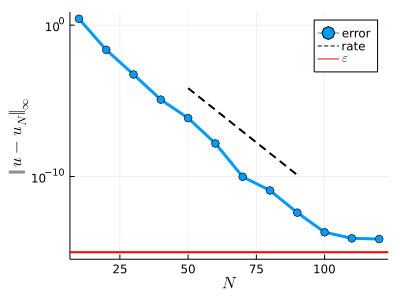

In [12]:
NN = 10:10:120
u = x -> cos( 1 / (0.2 + sin(x)^2) )

du = x -> ForwardDiff.derivative(u, x)
d2u = x -> ForwardDiff.derivative(du, x)
f = x -> u(x) - d2u(x)
xerr = range(0, 2π, length = 1_000)
solve(N) = triginterp(f, N) ./ (1 .+ kgrid(N).^2)
error(N) = norm(u.(xerr) - evaltrig.(xerr, Ref(solve(N))), Inf)
errs = error.(NN) 
plot(NN, errs, yscale = :log10, lw = 3, m=:o, ms=4, label = "error", 
              size = (400, 300), xlabel = L"N", ylabel = L"\Vert u - u_N \Vert_\infty")
plot!(NN[5:9], 1_000*exp.( - 0.33 * NN[5:9]), lw=2, ls=:dash, c=:black, label = "rate")
hline!([1e-15], lw=2, c=:red, label = L"\epsilon")


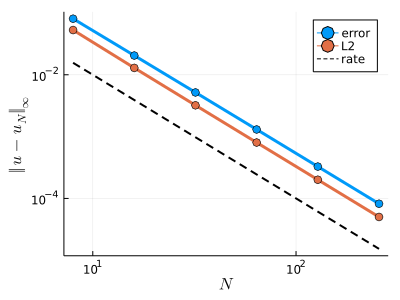

In [13]:
NN = (2).^(3:8)
u = x -> abs(sin(x))^3

du = x -> ForwardDiff.derivative(u, x)
d2u = x -> ForwardDiff.derivative(du, x)
f = x -> u(x) - d2u(x)
xerr = range(0, 2π, length = 1_000)
solve(N) = triginterp(f, N) ./ (1 .+ kgrid(N).^2)
error(N, p=Inf) = norm(u.(xerr) - evaltrig.(xerr, Ref(solve(N))), p) / (length(xerr))^(1/p)
errsInf = error.(NN, Inf) 
errs2 = error.(NN, 2) 

plot(NN, errsInf, yscale = :log10, xscale=:log10, lw = 3, m=:o, ms=4, label = "error", 
              size = (400, 300), xlabel = L"N", ylabel = L"\Vert u - u_N \Vert_\infty")
plot!(NN, errs2, lw=3, m=:o, ms=4, label = "L2")
nn = NN
plot!(nn, nn.^(-2), lw=2, ls=:dash, c=:black, label = "rate")
# hline!([1e-15], lw=2, c=:red, label = L"\epsilon")

### Summary Spectral Methods / Perspective

Numerical Analysis and Scientific Computing for (P)DEs : 
* regularity theory: how smooth are the solutions of the DE?
* approximation theory: how well can we approximate the solution in principle?
* discretisation, error analysis: how do we discretize the DE to guarantee convergence of the discretized solution? Optimal rates as predicted by approximation theory?
* Fast algorithms: scaling of computational cost matters! e.g. FFT provides close to optimal computational complexity, in general this is difficult to achieve. 



## Spectral methods for time-dependent, inhomogeneous and nonlinear problems

In the following we will implement a few examples that go beyond the basic theory above and showcase a few more directions in which one could explore spectral methods. We will see a few techniques to treat cases for which spectral methods are more difficult to use, namely for differential operators with inhomogeneous coefficients and for nonlinear problems.



### Wave equation 
$$
	u_{tt} = u_{xx}
$$
We first discretise in space, 
$$
	u_{tt} = u_{N, xx},
$$
then transform to Fourier coefficients, 
$$
	\frac{d^2\hat{U}_k}{d t^2}  = - k^2 \hat{U}_k,
$$
and finally discretize in time
$$
	\frac{\hat{U}_k^{n+1} - 2 \hat{U}_k^n + \hat{U}_k^{n-1}}{\Delta t^2}
	= - k^2 \hat{U}_k^n
$$


┌ Info: Saved animation to 
│   fn = /Users/ortner/gits/ApxThyApp/nb/tmp.gif
└ @ Plots /Users/ortner/.julia/packages/Plots/LSKOd/src/animation.jl:114


Plots.AnimatedGif("/Users/ortner/gits/ApxThyApp/nb/tmp.gif")
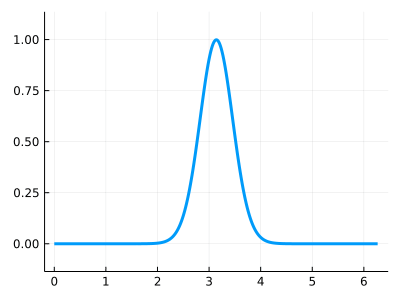

In [14]:
N = 20
dt = 0.2 / N
Tfinal = 30.0
u0 = x -> exp(-10*(1 + cos(x)))

let N = N, dt = dt, Tfinal=Tfinal, u0=u0
    xp = xgrid(200)
    k = kgrid(N)
    Û0 = triginterp(u0, N)
    Û1 = Û0  # zero initial velocity 
    @gif for n = 1:ceil(Int, Tfinal / dt)
        Û0, Û1 = Û1, 2 * Û1 - Û0 - dt^2 * k.^2 .* Û1
        plot(xp, evaltrig.(xp, Ref(Û1)), lw = 3, label = "", size = (400, 300), 
             xlims = [0, 2*π], ylims = [-0.1, 1.1] )
    end every 5
end

$$
	u_t + c(x) u_x = 0
$$
First discretise in time using the Leapfrog scheme 
$$
	\frac{u^{n+1} - u^{n-1}}{2 \Delta t} + c (u^n)_x = 0.
$$
Now we discretise both $c$ and $u^n$ using a trigonometric polynomials, $c \approx c_N$ and $u^n \approx u^n_N \in \mathcal{T}_N'$. We can easily apply $d/dx$ in the Fourier domain, $\hat{U}_k^n \to (i k) \hat{U}_k^n$, but what can we do with the product $c_N (u^n_N)_x$? The trick is to differentiate in the Fourier domain, but apply the product in real space, i.e., 
* Apply $d/dx$ in Fourier space
* Convert back to real space
* apply pointwise multiplication at interpolation nodes


┌ Info: Saved animation to 
│   fn = /Users/ortner/gits/ApxThyApp/nb/tmp.gif
└ @ Plots /Users/ortner/.julia/packages/Plots/LSKOd/src/animation.jl:114


Plots.AnimatedGif("/Users/ortner/gits/ApxThyApp/nb/tmp.gif")
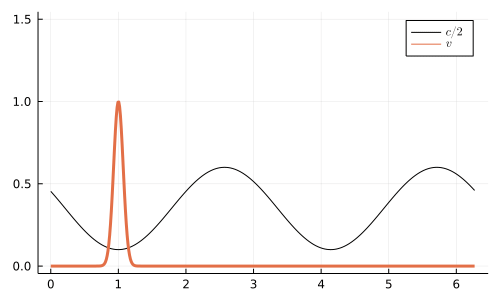

In [15]:

let     N = 256,  
        dt = π/(4N), 
        tmax = 16.0, 
        cfun = x -> 0.2 + sin(x - 1)^2, 
        u0 = x ->  exp(-100*(x-1)^2)

    X = xgrid(N)
    K = kgrid(N)
    t = 0.0
    # differentiation operator in Fourier space 
    D̂ = im*K

    # transport coefficient in real space 
    C = cfun.(X)
    # initial condition, we also need one additional v in the past
    # (this takes one step of the PDE backward in time)
    V = u0.(X)
    Vold = V + dt * C .* real.( ifft( D̂ .* fft(V) ) ) 

    function plot_soln(t, X, v, c)
        P = plot( xaxis = ([0, 2*π], ), yaxis = ([0.0, 1.5],) )
        plot!(X, 0.5*c, lw=1, c=:black, label = L"c/2")
        plot!(X, v, lw=3, label = L"v", size = (500, 300))
        return P
    end

    # time-stepping loop
    @gif for t = 0:dt:tmax
        # differentiation in reciprocal space
        W = real.( ifft( D̂ .* fft(V) ) )   
        # multiplication and update in real space
        V, Vold = Vold - 2 * dt * C .* W, V
        plot_soln(t, X, V, C)
    end every 20
end


### Nonlinear BVP

Steady state viscous Burgers equation
$$
		u u_x = \epsilon u_{xx} - 0.1 \sin(x)
$$
We write a nonlinear system 
$$
	F_j := u_N(x_j) u_{N,x}(x_j) - \epsilon u_{N,xx}(x_j) + 0.1 sin(x)
$$
and use a generic nonlinear solver to solve
$$
	F_j = 0, \qquad j = 0, \dots, 2N-1.
$$
This is not a magic bullet, often one needs specialized tools to solve these resulting nonlinear systems.


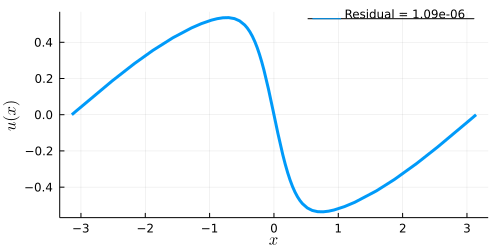

In [34]:
using SIAMFANLEquations: nsoli
N = 64
ϵ = 0.1
function burger(U)
    N = length(U) ÷ 2 
    k = kgrid(N)
    Û = fft(U) 
    F = sin.(xgrid(N))
    return real.(U .* ifft( im * k .* Û ) + ϵ * ifft( k.^2 .* Û ) .+ 0.1*F)
end
U0 = sin.(xgrid(N))
U = nsoli(burger, U0, maxit = 10_000)
Û = fft(U) / (2N)

plot(x -> real(evaltrig(x, Û)), -π, π, lw=3, size = (500, 250), 
     label = "Residual = " * (@sprintf("%.2e\n", norm(burger(U), Inf))), 
     xlabel = L"x", ylabel = L"u(x)")

We can use a naive manual continuation to get a solution for smaller $\epsilon$

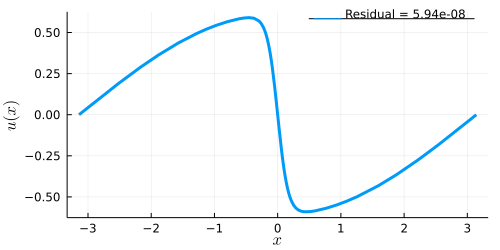

In [42]:
ϵ = 0.05
U1 = nsoli(burger, U, maxit = 1_000)
Û = fft(U1) / (2N)

plot(x -> real(evaltrig(x, Û)), -π, π, lw=3, size = (500, 250), 
     label = "Residual = " * (@sprintf("%.2e\n", norm(burger(U1), Inf))), 
     xlabel = L"x", ylabel = L"u(x)")

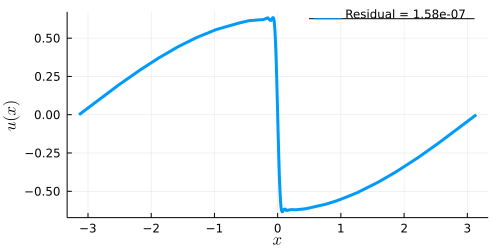

In [48]:
ϵ = 0.01
U2 = nsoli(burger, U1, maxit = 1_000)
Û = fft(U2) / (2N)

plot(x -> real(evaltrig(x, Û)), -π, π, lw=3, size = (500, 250), 
     label = "Residual = " * (@sprintf("%.2e\n", norm(burger(U2), Inf))), 
     xlabel = L"x", ylabel = L"u(x)")